In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from tqdm.notebook import tqdm
import random
import torch

# --- 实验设置 (与我们的 synthetic notebook 保持一致) ---
T = 6000                 # 我们将创建 6000 步的数据流
TARGET_ALPHA = 0.1       # 我们的长期目标 α

# --- 算法 1: 原版 ACI (固定 γ) ---
GAMMA_FIXED = 0.05       # 一个“调得还行”的固定 γ

# --- 算法 2: 我们的 ACI-CF (动态 γ_t) ---
GAMMA_MIN = 0.00         # 稳定时 γ 设为 0
GAMMA_MAX = 0.1         # 我们将 γ_max 设为与固定 ACI 相同，以公平比较
C_S = 3                # 我们的超参数 c (γ = c * S_t)
WINDOW_SIZE = 500        # 用于计算 S_t (近期性能) 的滑动窗口

# --- MMLU 主题定义 ---
# 先加载数据查看可用的subjects，然后随机选择
DATA_FILE = "mmlu_with_aps_scores.csv"
try:
    df_temp = pd.read_csv(DATA_FILE)
    all_subjects = sorted(df_temp['subject'].unique())
    print(f"CSV中所有可用的subjects ({len(all_subjects)}个):")
    print(all_subjects)
    print()
    
    # 随机选择1个用于校准，1个用于测试
    random.seed(42)  # 设置随机种子以便结果可复现
    selected_subjects = random.sample(all_subjects, min(20, len(all_subjects)))
    CALIBRATION_SUBJECTS = selected_subjects[:10]
    TEST_STREAM_SUBJECTS = selected_subjects[10:]
    
    print(f"随机选择的校准subjects (10个): {CALIBRATION_SUBJECTS}")
    print(f"随机选择的测试subjects (10个): {TEST_STREAM_SUBJECTS}")
except FileNotFoundError:
    print(f"警告: 未找到 {DATA_FILE}，使用默认subjects")
    # 用于创建我们 *固定* 的 Q_hat
    # CALIBRATION_SUBJECTS = [
    #     'high_school_us_history'
    # ]
    # # 用于构建 *动态* 的在线测试流
    # TEST_STREAM_SUBJECTS = [
    #     'professional_law'
    # ]

CSV中所有可用的subjects (19个):
['abstract_algebra', 'anatomy', 'astronomy', 'business_ethics', 'clinical_knowledge', 'college_biology', 'college_chemistry', 'college_computer_science', 'college_mathematics', 'college_medicine', 'college_physics', 'computer_security', 'conceptual_physics', 'econometrics', 'electrical_engineering', 'elementary_mathematics', 'formal_logic', 'global_facts', 'high_school_biology']

随机选择的校准subjects (10个): ['business_ethics', 'abstract_algebra', 'college_mathematics', 'college_computer_science', 'high_school_biology', 'astronomy', 'computer_security', 'anatomy', 'college_physics', 'formal_logic']
随机选择的测试subjects (10个): ['conceptual_physics', 'college_chemistry', 'global_facts', 'elementary_mathematics', 'college_biology', 'college_medicine', 'clinical_knowledge', 'econometrics', 'electrical_engineering']


In [5]:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine

print("SentenceTransformer library loaded.")

SentenceTransformer library loaded.


In [6]:
# -----------------------------------------------------------------
# Section 2 (已修改): 加载数据 & 创建 *分裂的* "固定模型" Q_hat
# -----------------------------------------------------------------

from sklearn.model_selection import train_test_split

# 加载你上一步生成的已标注数据
DATA_FILE = "mmlu_with_aps_scores.csv"
try:
    df_scores = pd.read_csv(DATA_FILE)
    print(f"成功加载 {len(df_scores)} 行 MMLU 数据。")
except FileNotFoundError:
    print(f"错误: 未找到 {DATA_FILE}")
    print("请确保你已成功运行第一个 notebook 并生成了该文件。")


# --- 1. 划分“校准主题”和“OOD主题” ---
df_cal_pool = df_scores[df_scores['subject'].isin(CALIBRATION_SUBJECTS)]
df_ood_pool = df_scores[df_scores['subject'].isin(TEST_STREAM_SUBJECTS)]

# --- 2. 找到“校准主题”的所有唯一 question_id ---
cal_all_qids = df_cal_pool['question_id'].unique()
print(f"从 {len(CALIBRATION_SUBJECTS)} 个校准主题中找到 {len(cal_all_qids)} 个唯一的问题。")

# --- 3. 将这些问题 50/50 分裂 ---
# D_cal 用于构建 Q_hat
# D_test_id 用于模拟“稳定/分布内”的测试流
cal_qids, test_id_qids = train_test_split(cal_all_qids, test_size=0.5, random_state=42)

print(f" -> {len(cal_qids)} 个问题用于构建 Q_hat (Calibration)")
print(f" -> {len(test_id_qids)} 个问题用于“稳定”测试流 (In-Distribution Test)")


# --- 4. 创建我们的“固定模型” Q_hat ---
# (A) 从 df_scores 中获取 D_cal 的 *所有* 行
df_cal = df_scores[df_scores['question_id'].isin(cal_qids)]
# (B) 我们只关心 D_cal 中“真实答案”的 APS 分数
calibration_scores = df_cal[df_cal['is_ground_truth'] == True]['aps_score'].values
print(f"\n成功从 {len(calibration_scores)} 个校准分数构建 Q_hat。")

# (C) 我们的模型 Q_hat(q) 就是这些校准分数的 *经验分位数* 函数
def hat_Q(q_level):
    if q_level <= 0: return -np.inf
    if q_level >= 1: return np.inf
    # 使用 'higher' 来匹配 (n+1)/n 的保守估计
    return np.quantile(calibration_scores, q_level, method='higher')

# 测试一下我们的 Q_hat
q_90 = hat_Q(1.0 - TARGET_ALPHA)
print(f"我们的固定阈值 q_hat (在 α=0.1 时) 是: {q_90:.4f}")

成功加载 11916 行 MMLU 数据。
从 10 个校准主题中找到 1325 个唯一的问题。
 -> 662 个问题用于构建 Q_hat (Calibration)
 -> 663 个问题用于“稳定”测试流 (In-Distribution Test)

成功从 662 个校准分数构建 Q_hat。
我们的固定阈值 q_hat (在 α=0.1 时) 是: 0.2686


In [7]:
# -----------------------------------------------------------------
# *** 新增步骤：预计算所有 MMLU 问题的 Embeddings ***
# -----------------------------------------------------------------
print("\n--- 正在预计算 Embeddings ---")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 1. 加载一个轻量级的 SBERT 模型
embed_model = SentenceTransformer('all-MiniLM-L6-v2', device=DEVICE)

# 2. 获取 *所有* 唯一的 MMLU 问题 (来自 df_scores)
unique_questions = df_scores[['question_id', 'question']].drop_duplicates().set_index('question_id')
question_texts = unique_questions['question'].tolist()
question_ids = unique_questions.index.tolist()

print(f"正在为 {len(question_texts)} 个唯一问题计算 embeddings...")

# 3. 计算所有 embeddings (这可能需要几分钟)
#    (如果你的 GPU 内存不足，可以减小 batch_size)
question_embeddings = embed_model.encode(
    question_texts, 
    batch_size=32, 
    show_progress_bar=True, 
    device=DEVICE
)

print("Embeddings 计算完成。")

# 4. 创建一个从 question_id -> embedding 的快速查找字典
embedding_map = {qid: emb for qid, emb in zip(question_ids, question_embeddings)}

# 5. 将 embeddings 添加到我们的主 DataFrame 中
df_scores['embedding'] = df_scores['question_id'].map(embedding_map)
print("Embeddings 已合并回主 DataFrame。")


--- 正在预计算 Embeddings ---
正在为 2979 个唯一问题计算 embeddings...


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings 计算完成。
Embeddings 已合并回主 DataFrame。


In [8]:
# -----------------------------------------------------------------
# Section 3 (已修改): 创建“跳跃”测试数据流
# -----------------------------------------------------------------

# --- 1. 准备好我们的两个问题“池” ---
# (我们只需要每个问题的 "question_id" 和 "ground_truth_label" 用于采样)

# (A) “稳定 / 分布内” (ID) 问题池
# 我们使用在第 2 节中预留的 test_id_qids
df_test_id_data = df_scores[df_scores['question_id'].isin(test_id_qids)]
df_test_id_gt = df_test_id_data[df_test_id_data['is_ground_truth'] == True].copy()
df_test_id_gt = df_test_id_gt.rename(columns={'choice_index': 'ground_truth_label'})
pool_id = df_test_id_gt[['question_id', 'ground_truth_label', 'embedding']]
print(f"创建了 {len(pool_id)} 个问题的“稳定” (ID) 池。")

# (B) “剧变 / 分布外” (OOD) 问题池
# 我们使用 TEST_STREAM_SUBJECTS
df_test_ood_data = df_scores[df_scores['subject'].isin(TEST_STREAM_SUBJECTS)]
df_test_ood_gt = df_test_ood_data[df_test_ood_data['is_ground_truth'] == True].copy()
df_test_ood_gt = df_test_ood_gt.rename(columns={'choice_index': 'ground_truth_label'})
pool_ood = df_test_ood_gt[['question_id', 'ground_truth_label', 'embedding']]
print(f"创建了 {len(pool_ood)} 个问题的“剧变” (OOD) 池。")


# --- 2. 创建 6000 步的“跳跃”数据流 (复刻 Fig A [cite: 2178-2180]) ---
test_stream_list = []
# 阶段 1: 稳定 (t < 2000)
test_stream_list.append(pool_id.sample(n=2000, replace=True))

# 阶段 2: 剧变 (2000 <= t < 4000)
# 从OOD池中随机选择一个subject用于剧变阶段
if len(pool_ood) == 0:
    raise ValueError("OOD池为空，无法创建剧变阶段")
# 从pool_ood中随机选择一个subject
random.seed(42)
ood_subjects_in_pool = pool_ood['question_id'].str.split('_').str[0].unique()
selected_ood_subject = random.choice(ood_subjects_in_pool)
pool_ood_jump1 = pool_ood[pool_ood['question_id'].str.startswith(selected_ood_subject)]
if len(pool_ood_jump1) == 0:
    # 如果按subject筛选失败，直接使用整个pool_ood
    pool_ood_jump1 = pool_ood
print(f"剧变阶段使用subject: {selected_ood_subject} ({len(pool_ood_jump1)} 个问题)")
test_stream_list.append(pool_ood_jump1.sample(n=2000, replace=True))

# 阶段 3: 恢复稳定 (t >= 4000)
test_stream_list.append(pool_id.sample(n=2000, replace=True))

# 将数据流（DataFrames 列表）合并为一个 DataFrame
test_stream_df = pd.concat(test_stream_list).reset_index(drop=True)

# --- 3. 将完整的、带所有选项（A,B,C,D）分数的数据合并进来 ---
# (这步与之前完全相同)
test_stream_full_df = test_stream_df[['question_id', 'ground_truth_label']].merge(
    df_scores,
    on='question_id',
    suffixes=('_stream', '_choices') # 避免 'ground_truth_label' 列名冲突
)

print(f"\n成功创建了 {T} 步的 MMLU '跳跃' 数据流。")
print(test_stream_df.head())

创建了 663 个问题的“稳定” (ID) 池。
创建了 1654 个问题的“剧变” (OOD) 池。
剧变阶段使用subject: elementary (378 个问题)

成功创建了 6000 步的 MMLU '跳跃' 数据流。
            question_id  ground_truth_label  \
0  computer_security_66                   1   
1   abstract_algebra_60                   3   
2           anatomy_131                   3   
3   computer_security_4                   0   
4   abstract_algebra_70                   3   

                                           embedding  
0  [-0.050522517, 0.044323206, -0.011736025, -0.0...  
1  [0.024383634, 0.04275908, 0.023356741, -0.0064...  
2  [0.035182904, 0.009765691, -0.0755599, -0.0076...  
3  [-0.069587186, 0.008206034, -0.035224378, -0.0...  
4  [-0.11749873, 0.09712709, -0.02765296, 0.08815...  


In [9]:
# --- 初始化算法状态 ---
# 1. Baseline (不学习)
alpha_baseline = np.full(T, TARGET_ALPHA)
err_baseline = []

# 2. ACI (固定 γ)
alpha_aci_fixed = np.zeros(T)
alpha_aci_fixed[0] = TARGET_ALPHA
err_aci_fixed = []

# 3. ACI-CF (我们的动态 γ_t)
alpha_aci_ours = np.zeros(T)
alpha_aci_ours[0] = TARGET_ALPHA
err_aci_ours = []
gamma_t_history = []
dist_history = []  # 记录每个时刻与质心的距离

# --- 预先获取 embedding 向量以加快循环速度 ---
# (test_stream_df 包含了按 t 排序的正确 embedding)
all_embeddings = np.stack(test_stream_df['embedding'].values)

# --- 计算 calibration dataset 的 embedding 质心 ---
# 从 df_cal 中获取所有唯一的 question_id 的 embeddings
cal_question_ids = df_cal['question_id'].unique()
cal_embeddings_list = []
for qid in cal_question_ids:
    # 获取该问题的 embedding (从 df_scores 中)
    cal_emb = df_scores[df_scores['question_id'] == qid]['embedding'].iloc[0]
    cal_embeddings_list.append(cal_emb)
cal_embeddings = np.stack(cal_embeddings_list)
cal_centroid = np.mean(cal_embeddings, axis=0)  # 计算质心
print(f"已计算 calibration dataset 的 embedding 质心 (基于 {len(cal_question_ids)} 个问题)")

# 按 question_id 分组，以便快速查询
# 我们使用 groupby().get_group() 而不是在 T*4 的 DF 上循环
test_stream_grouped = test_stream_full_df.groupby('question_id')
question_ids_in_stream = test_stream_df['question_id'].unique()

print("开始运行 MMLU 模拟...")
# --- 模拟 T 步 ---
# 我们按问题（T 步）循环，而不是按选项（T*4 步）循环
for t in tqdm(range(T)):
    
    # 1. 获取当前 "世界" 状态（当前问题）
    current_question_id = test_stream_df.loc[t, 'question_id']
    current_ground_truth_label = test_stream_df.loc[t, 'ground_truth_label']
    
    # 2. 获取该问题的所有 4 个选项的数据
    # (这包括了它们的 APS 分数)
    question_choices_df = test_stream_grouped.get_group(current_question_id)

    # --- 算法 1: Baseline ---
    q_baseline = hat_Q(1.0 - alpha_baseline[t])
    # 建立预测集 C_hat
    set_baseline = question_choices_df[question_choices_df['aps_score'] <= q_baseline]['choice_index'].values
    # 判断错误
    is_error_baseline = 1.0 if current_ground_truth_label not in set_baseline else 0.0
    err_baseline.append(is_error_baseline)
    
    # --- 算法 2: ACI (固定 γ) ---
    q_aci_fixed = hat_Q(1.0 - alpha_aci_fixed[t])
    set_aci_fixed = question_choices_df[question_choices_df['aps_score'] <= q_aci_fixed]['choice_index'].values
    is_error_aci_fixed = 1.0 if current_ground_truth_label not in set_aci_fixed else 0.0
    err_aci_fixed.append(is_error_aci_fixed)
    
    if t < T-1:
        alpha_aci_fixed[t+1] = alpha_aci_fixed[t] + GAMMA_FIXED * (TARGET_ALPHA - is_error_aci_fixed)
        
    # --- 算法 3: ACI-CF (我们的动态 γ_t) ---
    q_aci_ours = hat_Q(1.0 - alpha_aci_ours[t])
    set_aci_ours = question_choices_df[question_choices_df['aps_score'] <= q_aci_ours]['choice_index'].values
    is_error_aci_ours = 1.0 if current_ground_truth_label not in set_aci_ours else 0.0
    err_aci_ours.append(is_error_aci_ours)
    
    # -----------------------------------------------------------------
    # *** 我们的核心创新 (与 synthetic notebook 相同) ***
    # -----------------------------------------------------------------
    # 1. 用 "近期性能" 计算 S_t (Φ_t 的代理)
    if t < WINDOW_SIZE:
        # 对于 t=0，无法计算 t-1，使用固定值
        gamma_t = GAMMA_FIXED
        # 计算 t=0 时刻与质心的距离
        v_t = all_embeddings[t]
        dist_t = cosine(v_t, cal_centroid)
        dist_history.append(dist_t)
    else:
        # recent_avg_error = np.mean(err_aci_ours[t-WINDOW_SIZE : t])
        # s_t = np.abs(recent_avg_error - TARGET_ALPHA)

        # 计算 t 时刻和 t-1 时刻与 calibration dataset 质心的距离
        v_t = all_embeddings[t]
        v_t_minus_1 = all_embeddings[t-1]
        v_t_minus_window = np.mean(all_embeddings[t-WINDOW_SIZE : t], axis=0)
        
        # 计算与质心的距离
        dist_t = cosine(v_t, cal_centroid)  # t 时刻与质心的距离
        dist_t_minus_1 = cosine(v_t_minus_1, cal_centroid)  # t-1 时刻与质心的距离
        dist_t_minus_window = cosine(v_t_minus_window, cal_centroid)  # t-window 时刻与质心的距离
        
        # 记录距离
        dist_history.append(dist_t)
        
        # 使用两个距离的差值作为 s_t
        # s_t = np.abs(dist_t - dist_t_minus_1)  # 使用绝对值确保非负
        s_t = np.abs(dist_t - dist_t_minus_window)  # 使用绝对值确保非负

        gamma_t = GAMMA_MIN + C_S * s_t
    
    # 2. 用 γ_t* ∝ Φ_t (我们用 S_t 作为代理)
    
    gamma_t = np.clip(gamma_t, GAMMA_MIN, GAMMA_MAX)
    gamma_t_history.append(gamma_t)
    
    # 更新 (下一轮使用)
    if t < T-1:
        alpha_aci_ours[t+1] = alpha_aci_ours[t] + gamma_t * (TARGET_ALPHA - is_error_aci_ours)

print("MMLU 模拟完成。")

已计算 calibration dataset 的 embedding 质心 (基于 662 个问题)
开始运行 MMLU 模拟...


  0%|          | 0/6000 [00:00<?, ?it/s]

MMLU 模拟完成。


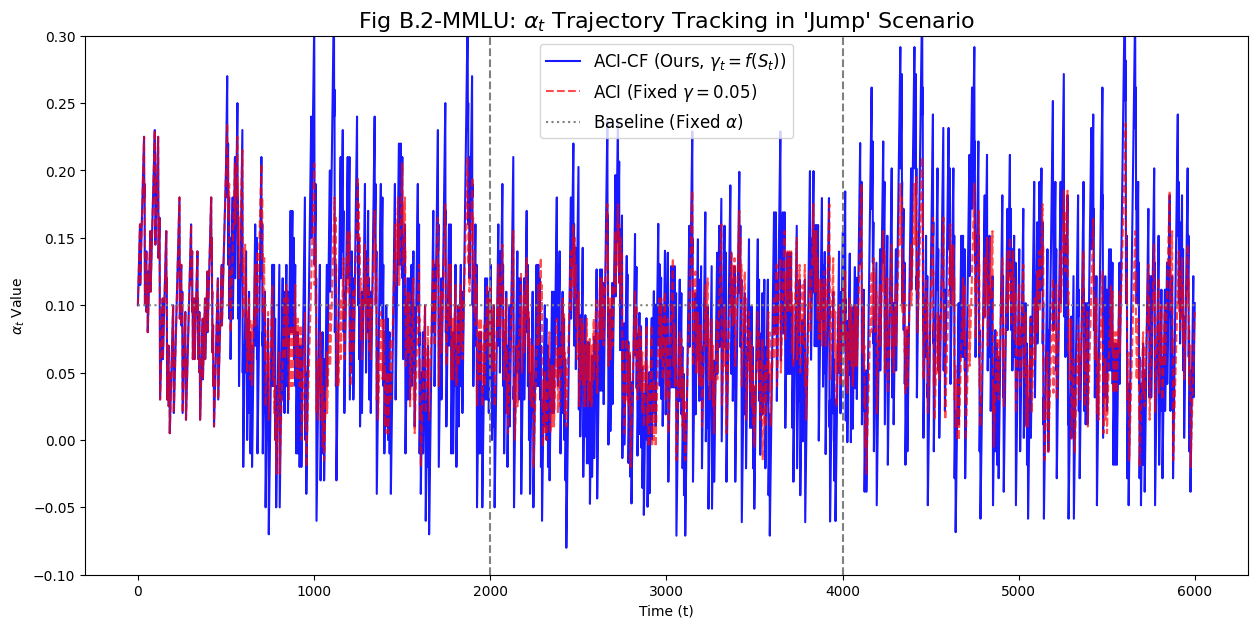

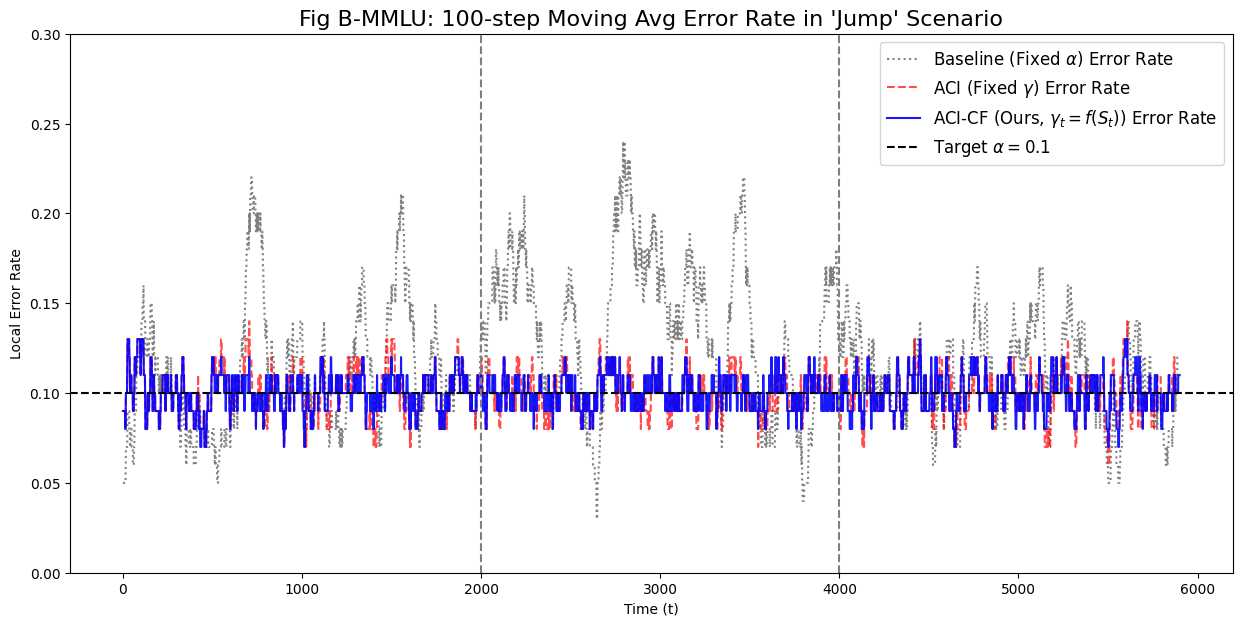

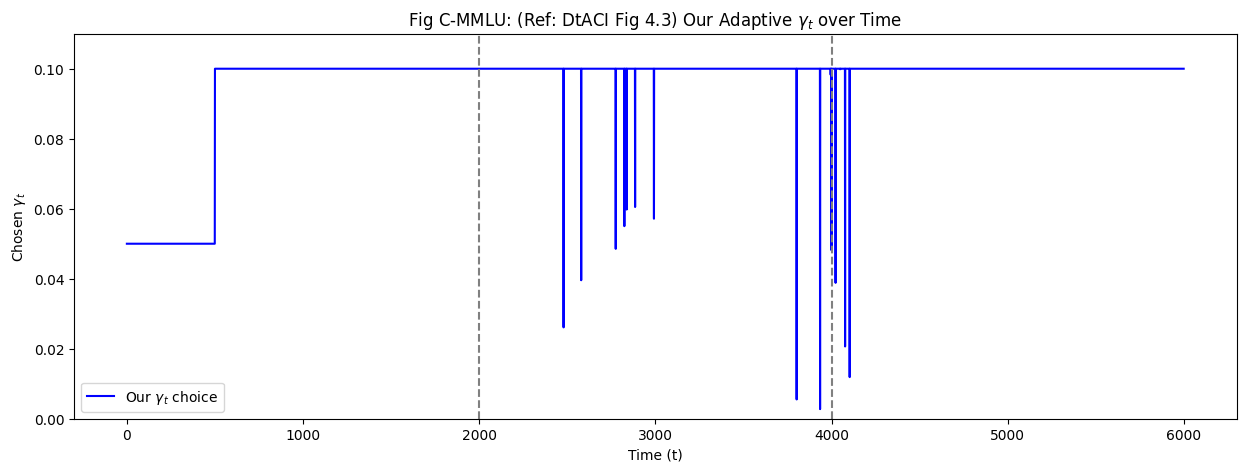

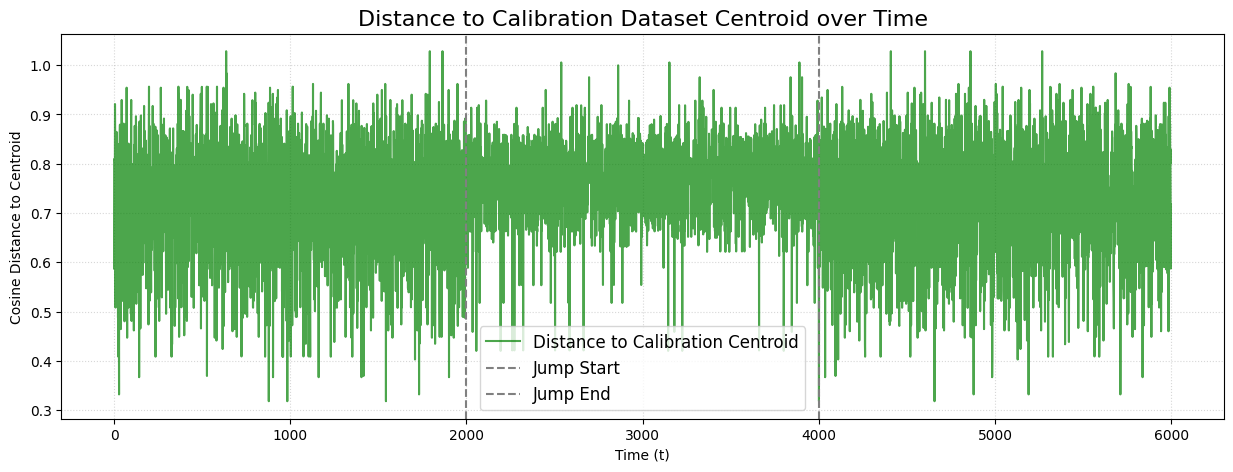

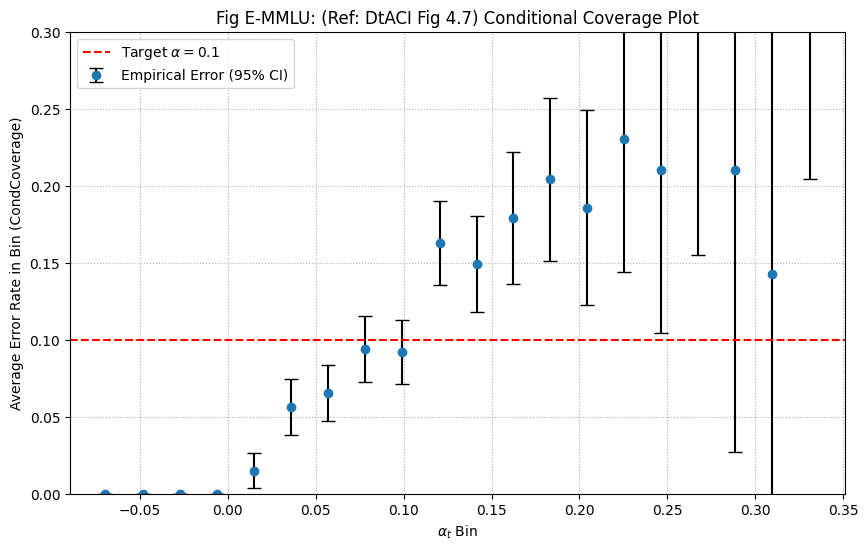

In [10]:
# --- 1. "Money Plot" (Fig B): 追踪 α_t ---
# 我们没有 "Ground Truth α_t*"，因为这是真实数据
# 但我们可以绘制 "Baseline Error" 作为参考
# --- 1. (新图) 绘制 "alpha_t" 轨迹 (Fig B 的姊妹图) ---
# 这张图展示了算法的 *内部状态*
plt.figure(figsize=(15, 7))

# 绘制我们的 ACI-CF (蓝线)
plt.plot(alpha_aci_ours, label="ACI-CF (Ours, $\gamma_t=f(S_t)$)", color='blue', alpha=0.9)

# 绘制固定 ACI (红线)
plt.plot(alpha_aci_fixed, label=f"ACI (Fixed $\gamma={GAMMA_FIXED}$)", color='red', alpha=0.7, linestyle='--')

# 绘制 Baseline (灰线)
plt.plot(alpha_baseline, label="Baseline (Fixed $\\alpha$)", color='gray', linestyle=':')

plt.title("Fig B.2-MMLU: $\\alpha_t$ Trajectory Tracking in 'Jump' Scenario", fontsize=16)
plt.xlabel("Time (t)")
plt.ylabel("$\\alpha_t$ Value")
plt.legend(fontsize=12)
plt.axvline(2000, color='gray', linestyle='--')
plt.axvline(4000, color='gray', linestyle='--')
# 我们可以把 Y 轴放大，看得更清楚
plt.ylim(-0.1, 0.3) 
plt.show()


# 计算滑动平均错误率 (更平滑)
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# 绘制滑动平均错误率
plt.figure(figsize=(15, 7))
plt.plot(moving_average(err_baseline), label="Baseline (Fixed $\\alpha$) Error Rate", color='gray', linestyle=':')
plt.plot(moving_average(err_aci_fixed), label="ACI (Fixed $\gamma$) Error Rate", color='red', alpha=0.7, linestyle='--')
plt.plot(moving_average(err_aci_ours), label="ACI-CF (Ours, $\gamma_t=f(S_t)$) Error Rate", color='blue', alpha=0.9)

plt.axhline(TARGET_ALPHA, color='black', linestyle='--', label=f'Target $\\alpha={TARGET_ALPHA}$')
plt.title("Fig B-MMLU: 100-step Moving Avg Error Rate in 'Jump' Scenario", fontsize=16)
plt.xlabel("Time (t)")
plt.ylabel("Local Error Rate")
plt.legend(fontsize=12)
plt.axvline(2000, color='gray', linestyle='--')
plt.axvline(4000, color='gray', linestyle='--')
plt.ylim(0, 0.3) # 放大
plt.show()

# --- 2. "Why Plot" (Fig C): 我们选择的 γ_t ---
plt.figure(figsize=(15, 5))
plt.plot(gamma_t_history, label="Our $\gamma_t$ choice", color='blue')
plt.title("Fig C-MMLU: (Ref: DtACI Fig 4.3) Our Adaptive $\gamma_t$ over Time")
plt.xlabel("Time (t)")
plt.ylabel("Chosen $\gamma_t$")
plt.axvline(2000, color='gray', linestyle='--')
plt.axvline(4000, color='gray', linestyle='--')
plt.ylim(0, GAMMA_MAX * 1.1)
plt.legend()
plt.show()

# --- 2.5. 绘制 dist (与质心的距离) 随时间的变化 ---
plt.figure(figsize=(15, 5))
plt.plot(dist_history, label="Distance to Calibration Centroid", color='green', alpha=0.7)
plt.title("Distance to Calibration Dataset Centroid over Time", fontsize=16)
plt.xlabel("Time (t)")
plt.ylabel("Cosine Distance to Centroid")
plt.axvline(2000, color='gray', linestyle='--', label='Jump Start')
plt.axvline(4000, color='gray', linestyle='--', label='Jump End')
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

# --- 3. "Stability Plot" (Fig E): 条件覆盖率 ---
df_diag = pd.DataFrame({
    'alpha_t': alpha_aci_ours,
    'error': err_aci_ours
})

# 1. 将 α_t 分箱
num_bins = 20
df_diag['alpha_bin'] = pd.cut(df_diag['alpha_t'], bins=num_bins)

# 2. 计算每个 bin 的统计数据
grouped = df_diag.groupby('alpha_bin', observed=True)['error']
stats = grouped.agg(['mean', 'count'])

# 3. 计算 95% CI 误差棒
p = stats['mean']
n = stats['count']
sem = np.sqrt(p * (1 - p) / n)
z_score = st.norm.ppf(0.975) # 1.96
y_err = z_score * sem

bin_centers = [b.mid for b in stats.index]

# 4. 绘图 (使用 plt.errorbar)
plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, stats['mean'], yerr=y_err, fmt='o', color='C0',
             ecolor='black', capsize=5, label='Empirical Error (95% CI)')

plt.axhline(TARGET_ALPHA, color='red', linestyle='--', label=f'Target $\\alpha = {TARGET_ALPHA}$')
plt.xlabel("$\\alpha_t$ Bin")
plt.ylabel("Average Error Rate in Bin (CondCoverage)")
plt.title("Fig E-MMLU: (Ref: DtACI Fig 4.7) Conditional Coverage Plot")
plt.legend()
plt.ylim(0, 0.3) 
plt.grid(True, linestyle=':')
plt.show()